<h4 align="center"> In The Name of God </h4>

------
 <h1 align="center"> Artificial Intelligence Project </h1>
 <h3 align="center"> Hosein Ghaderi   &   Ali Khosrozadeh   &   Fatemeh Hajizadeh </h3>
 <h3 align="center"> Main Code (1) </h3>

------

Used **libraries**

In [1]:

#Python standard libraries
import os                                                             #Managing files and paths in the operating system.
import numpy as np                                                    #A library for numerical calculations with arrays
                                                                      #and matrices and performing fast mathematical operations.
import librosa                                                        #A library for audio processing and analysis.

#Machine learning tools
import tensorflow as tf                                               #Deep learning library for building and training neural networks
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder                        #sklearn: A library for machine learning and data preprocessing
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report

#Visualization tools
import seaborn as sns                                                 #A library for data visualization and data distribution analysis
import matplotlib.pyplot as plt                                       #Core library for drawing graphs and visualizing features or results

**Functions used to develop the prediction model**

In [2]:
# Feature extraction
def extract_features(file_path):

    #Upload audio file
    audio, sr = librosa.load(file_path, sr=None)
    # Extracting the intensity of energy in 12 musical steps
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    # Extract the number of times the signal crosses the zero axis
    zcr = librosa.feature.zero_crossing_rate(audio)
    zcr_mean = np.mean(zcr)
    #Mel Spec.
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_spec_mean = np.mean(mel_spec, axis=1)
    # Extracting energy differences between different frequency segments
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
    # Extracting frequency-related features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    #Extracting how smooth or flat the spectrum is
    flatness = librosa.feature.spectral_flatness(y=audio)
    flatness_mean = np.mean(flatness)

    features = np.hstack([
         mfcc_mean,
         spectral_contrast_mean,
         chroma_mean ,
         mel_spec_mean  ,
         zcr_mean   ,
         flatness_mean])

    return features


In [3]:
#Classification

def load_data(audio_folder):
    features = []
    labels = []
    filenames = []

    #All folders inside the main folder (audio_folder) are read.
    for label in os.listdir(audio_folder):
        label_folder = os.path.join(audio_folder, label)
        if os.path.isdir(label_folder):
            for file in os.listdir(label_folder):
                if file.endswith(".wav"):
                    file_path = os.path.join(label_folder, file)
                    feature = extract_features(file_path)
                    features.append(feature)
                    labels.append(label)
                    filenames.append(file)

    return np.array(features), np.array(labels), filenames

In [4]:
def predictor(file_path):

    #Load audio file > Remove noise > Extract features > Transform features to fit the model > Predict > Convert indices to genus name > Finish
    audio, sr = librosa.load(file_path, sr=None)
    audio =librosa.effects.preemphasis(audio)
    features = extract_features(file_path)
    features = features.reshape(1, -1)
    predictions = model.predict(features)
    result = np.argsort(predictions[0])
    prediction = predictions[0][result]
    name = encoder.inverse_transform(result)

    # In this section, the input features (features[0]) are sorted in order of importance.
    dominant_features = features[0]
    important_features = np.argsort(dominant_features)[::-1][:7]
    #The reasons for selecting each important feature are created as a list of strings, each representing the feature name and its value.
    reasons = [
        f"Feature {i} with value {dominant_features[i]:.4f}"
        for i in important_features
    ]

    return {
        "Top Predictions": [
            {"Type": name, "Similarity": f"{prob*100:.2f}%", "Reason": reasons}
            for name, prob in zip(name, prediction)
        ]
    }

**Start model development**

In [5]:
#Data retrieval

from google.colab import drive
drive.mount('/content/drive')

audio_folder = '/content/drive/MyDrive/My_Data'
X, y , filenames = load_data(audio_folder)

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [6]:
#Convert folder names to numbers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(X, y_encoded, filenames, test_size=0.2, random_state=41
                                                                                     )

#CNN
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


#It helps to pay more attention to classes with less data.
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Tranning
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)#, callbacks=[early_stopping])

# testing
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.3392 - loss: 5.0780 - val_accuracy: 0.8644 - val_loss: 0.4734
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6305 - loss: 0.7913 - val_accuracy: 0.9153 - val_loss: 0.1801
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9358 - loss: 0.1879 - val_accuracy: 0.9661 - val_loss: 0.1028
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9546 - loss: 0.1467 - val_accuracy: 0.9831 - val_loss: 0.0690
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9712 - loss: 0.0890 - val_accuracy: 0.9831 - val_loss: 0.0540
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9814 - loss: 0.0619 - val_accuracy: 0.9831 - val_loss: 0.0543
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9935 - loss: 0.0432 - val_accuracy: 0.9831 - val_loss: 0.0420
Epoch 8/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0414 - val_accuracy: 0.9831 - val_loss: 0.0383


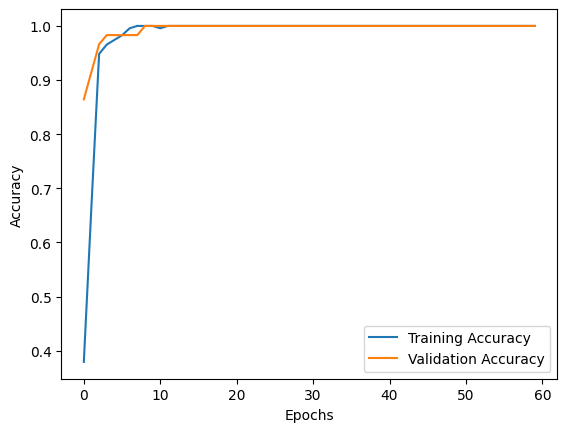

In [8]:
# رسم نمودار دقت بر حسب epoch‌ها
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Class Glass: Example filename -> Aluminum 14.wav
Class Iron: Example filename -> Glass 63.wav
Class Pelastic: Example filename -> Iron 2.wav
Class Aluminium: Example filename -> Plastic 17.wav
Class Wood: Example filename -> Wood 37.wav
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

       Glass       1.00      1.00      1.00        12
        Iron       1.00      1.00      1.00         9
    Pelastic       1.00      1.00      1.00        11
   Aluminium       1.00      1.00      1.00        12
        Wood       1.00      1.00      1.00        15

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59



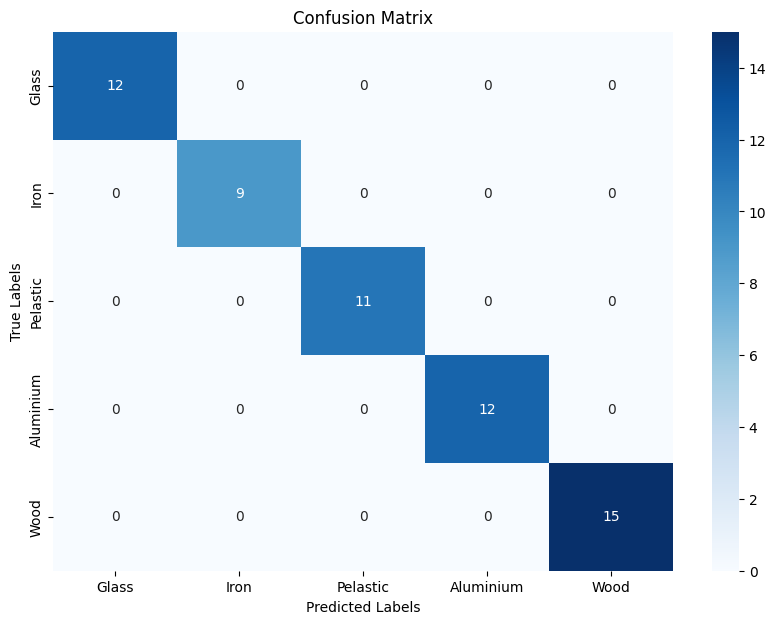

In [13]:
class_names = ['Glass', 'Iron', 'Pelastic', 'Aluminium', 'Wood']

#  Find the category name
for label in np.unique(y_test):
    sample_idx = np.where(y_test == label)[0][0]
    print(f"Class {class_names[label]}: Example filename -> {filenames_test[sample_idx]}")

# پیش‌بینی دسته‌ها
y_pred = np.argmax(model.predict(X_test), axis=1)

# نمایش ماتریس
cm = confusion_matrix(y_test, y_pred)


#گزارش عملکرد
print(classification_report(y_test, y_pred, target_names=class_names))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [10]:
# test
predictions = model.predict(X_test)

predicted_labels = encoder.inverse_transform(np.argmax(predictions, axis=1))
true_labels = encoder.inverse_transform(y_test)

num_samples = min(5, len(X_test))
#num_samples = max(10, len(X_test))
for i in range(num_samples):
    print(f"Sample {i+1}:")
    print(f"File: {filenames_test[i]}")
    print(f"True label: {true_labels[i]}")
    print(f"Predicted label: {predicted_labels[i]}")
    print("-" * 50)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Sample 1:
File: Plastic 17.wav
True label: plastic
Predicted label: plastic
--------------------------------------------------
Sample 2:
File: Iron 2.wav
True label: iron
Predicted label: iron
--------------------------------------------------
Sample 3:
File: Glass 63.wav
True label: glass
Predicted label: glass
--------------------------------------------------
Sample 4:
File: Aluminum 14.wav
True label: Al
Predicted label: Al
--------------------------------------------------
Sample 5:
File: Wood 37.wav
True label: wood
Predicted label: wood
--------------------------------------------------


**For Your Test**

In [12]:
#test_file = r"/content/drive/MyDrive/ForTest/TestG51.wav"
test_file = r"/content/Fe.wav"
result = predictor(test_file)

#Finding the best prediction
if "Top Predictions" in result and result["Top Predictions"]:
    best_prediction = max(result["Top Predictions"], key=lambda x: x["Similarity"])
    print("Best Prediction:")
    print(f"  Type: {best_prediction['Type']}")
    print(f"  Similarity: {best_prediction['Similarity']}")
    print(f"  Reasons: {', '.join(best_prediction['Reason'])}")
else:
    print("No predictions available.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Best Prediction:
  Type: iron
  Similarity: 99.05%
  Reasons: Feature 1 with value 45.3193, Feature 19 with value 35.3293, Feature 3 with value 33.2080, Feature 18 with value 25.7980, Feature 7 with value 20.3324, Feature 17 with value 14.4123, Feature 13 with value 12.6078
